Episode 1990/2000.

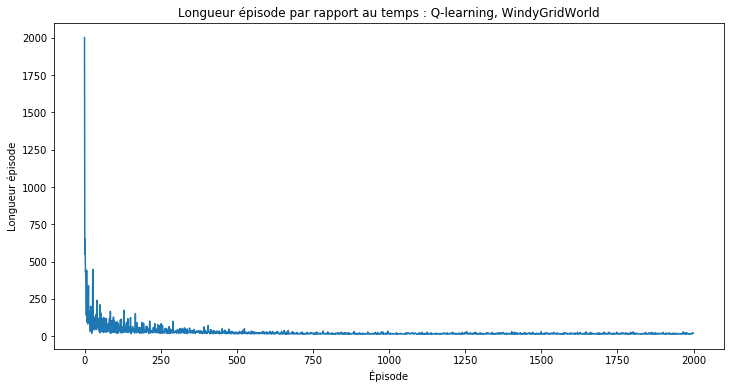

In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Optimisation de politique avec méthode Q-learning
Politique epsilon-vorace
Environnement WindyGridWorldEnv du livre de Barto&Sutton 2018 Ex.6.5
Le code de l'environnement est tiré de 
https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/windy_gridworld.py
"""
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from collections import defaultdict
import itertools
import sys
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

import matplotlib
from matplotlib import pyplot as plt

def afficher_statistiques(longueur_episode):
    """
    Afficher l'évolution des longueurs d'épisodes avec le temps
    """
    figure1 = plt.figure(figsize=(12,6))
    plt.plot(longueur_episode)
    plt.xlabel("Épisode")
    plt.ylabel("Longueur épisode")
    plt.title("Longueur épisode par rapport au temps : Q-learning, WindyGridWorld")

def politique_optimale_Q(env, nombre_episodes, gamma=1.0, alpha= 0.1, epsilon=0.1):
    """
    Prédire la valeur de la politique par la méthode Q
        politique: fonction pi
        env: environnement de type OpenAI gym
        nombre_episodes: nombre d'épisodes générés pour les estimations
        gamma: facteur d'escompte des récompenses futures
    Retour:
        V: Dictionnaire(etat,valeur)
    """

    longueur_episode = np.zeros(nombre_episodes)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(nombre_episodes):
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, nombre_episodes), end="")
            sys.stdout.flush()

         # Un episode est un tableau de tuples (etat, action, recompense)
        etat = env.reset()
        for t in itertools.count():
            
            # Choisir action selon politique e-vorace
            probabilites_actions = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
            meilleure_action = np.argmax(Q[etat])
            probabilites_actions[meilleure_action] += (1.0 - epsilon)
            action = np.random.choice(np.arange(len(probabilites_actions)), p=probabilites_actions)
            etat_suivant, recompense, final, _ = env.step(action)            
            meilleure_action_suivante = np.argmax(Q[etat_suivant])
            
            cible = recompense+gamma*Q[etat_suivant][meilleure_action_suivante]
            delta = cible-Q[etat][action]
            Q[etat][action] += alpha*delta
            
            if final:
                longueur_episode[i_episode] = t
                break
            etat = etat_suivant
    return Q,longueur_episode

env = WindyGridworldEnv()

Q,longueur_episode = politique_optimale_Q(env, nombre_episodes=2000,gamma=1.0, alpha= 0.1, epsilon=0.1)
afficher_statistiques(longueur_episode)

In [2]:
""" Test du jeu après optimisation de Q """
nb_episodes = 3
max_etapes = 99 
env.reset()
recompenses = []
env = WindyGridworldEnv()


for episode in range(nb_episodes):
    etat = env.reset()
    final = False
    total_recompenses = 0
    print("**********************************")
    print("Épisode : ", episode)

    for etape in range(max_etapes):
        env.render()
        action = np.argmax(Q[etat])
        
        etat_suivant, recompense, final, _ = env.step(action)
        
        total_recompenses += recompense
        
        if final:
            recompenses.append(total_recompenses)
            print ("Total des récompenses de l'épisode", total_recompenses)
            break
        etat = etat_suivant
env.close()
print ("Moyenne de récompenses par épisode: " +  str(sum(recompenses)/nb_episodes))

**********************************
Épisode :  0
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o 

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  x
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

Total des récompenses de l'épisode -15

In [3]:
Q

defaultdict(<function __main__.politique_optimale_Q.<locals>.<lambda>()>,
            {30: array([-15.76976551, -15.        , -15.49633364, -15.93159568]),
             20: array([-14.91781585, -14.89661104, -14.9955668 , -14.94298493]),
             10: array([-14.3249495 , -14.26856239, -14.38326585, -14.24559385]),
             0: array([-13.95752034, -13.96061833, -14.02944   , -13.95430769]),
             1: array([-13.55372629, -13.55183943, -13.57590893, -13.55153327]),
             2: array([-12.97903788, -12.90428885, -12.95550647, -12.92396941]),
             3: array([-12.19383555, -11.99893171, -12.30920703, -12.36882073]),
             4: array([-11.41098855, -11.        , -11.57988501, -11.93007313]),
             12: array([-13.03394272, -12.94533934, -12.97703396, -12.98334843]),
             11: array([-13.73493091, -13.7107753 , -13.71350818, -13.69255488]),
             13: array([-12.18287636, -11.99993315, -12.09460493, -12.32949758]),
             5: array([-10.85